# Convolutional neural networks for artistic style transfer

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. It is meant to go along with a [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/) that provides more context, and explains a lot of the theory behind the steps that follow.



# Mount Google Drive
###  1.  Install components
###  2.  Authentication
###  3.  Mount Drive
###  4.  Change Folders
###  5.  Access image and style files

# Sharing related items:
### If you are received a shared version of this file,  you need to create an equivalent folder tree:
###  -  drive/app/NST_Workshop_20180414/notebooks
###  -  drive/app/NST_Workshop_20180414/notebooks/images

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [6]:
import os
os.chdir("drive/app/NST_Workshop_20180414")
os.chdir("notebooks")
!ls -al

total 7892
drwxr-xr-x 2 root root    4096 Mar 26 04:28 .
drwxr-xr-x 2 root root    4096 Apr  6 18:04 ..
-rw-r--r-- 1 root root   25380 Apr  6 18:17 1_Linear_Image_Classifier.ipynb
-rw-r--r-- 1 root root   17463 Apr  6 15:42 2_Neural_Network-based_Image_Classifier-1.ipynb
-rw-r--r-- 1 root root  495120 Apr  6 15:57 3_Neural_Network-based_Image_Classifier-2.ipynb
-rw-r--r-- 1 root root   92106 Apr  6 16:16 4_Convolutional_Neural_Network-based_Image_Classifier.ipynb
-rw-r--r-- 1 root root 2471043 Apr  8 00:07 5_VGG_Net_16_the_easy_way.ipynb
-rw-r--r-- 1 root root 2133295 Mar 26 17:44 6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb
-rw-r--r-- 1 root root 2117014 Apr  7 18:12 7_GPU_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb
drwxr-xr-x 2 root root    4096 Apr  8 21:08 drive
drwxr-xr-x 2 root root    4096 Mar 26 04:28 images
drwxr-xr-x 2 root root    4096 Apr  6 15:50 MNIST_data
-rw-r--r-- 1 root root  706895 Apr  8 21:07 NST_Packaged.ipynb


In [7]:
!date

Sun Apr  8 21:08:15 UTC 2018


In [9]:
!ls -al images

total 7872
drwxr-xr-x 2 root root    4096 Mar 26 04:28 .
drwxr-xr-x 2 root root    4096 Mar 26 04:28 ..
-rw-r--r-- 1 root root    5811 Mar 26 04:42 cheetah.jpg
-rw-r--r-- 1 root root  521449 Apr  7 04:44 Chotani.jpg
-rw-r--r-- 1 root root 1433327 Mar 26 04:28 content-feature.png
-rw-r--r-- 1 root root  215334 Apr  8 00:00 elephant.jpg
-rw-r--r-- 1 root root 2648758 Mar 26 04:28 example.gif
-rw-r--r-- 1 root root    7615 Mar 27 04:05 fish2.jpg
-rw-r--r-- 1 root root    6187 Mar 27 03:54 fish.jpg
-rw-r--r-- 1 root root  367312 Apr  7 06:24 GC.jpg
-rw-r--r-- 1 root root    7335 Mar 27 03:35 gg.jpg
-rw-r--r-- 1 root root  269687 Apr  6 17:21 harker.jpg
-rw-r--r-- 1 root root   81046 Mar 26 04:28 hugo.jpg
-rw-r--r-- 1 root root  307793 Mar 26 04:28 imagenet-sample.jpg
-rw-r--r-- 1 root root   56916 Mar 26 04:28 linear.png
-rw-r--r-- 1 root root   48233 Mar 26 04:28 mnist-sample.png
-rw-r--r-- 1 root root  135388 Mar 26 04:28 neural-network-1-hidden.png
-rw-r--r-- 1 root root  158718 Mar 26 

In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


from PIL import Image
import requests

## Load and preprocess the content and style images

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

In [0]:
def generate_outfile(content_path, style_path, iteration=10):
  content_base = os.path.basename(content_image_path)
  style_base = os.path.basename(style_image_path)
  full_path = "out/" + os.path.splitext(content_base)[0] + "_" + os.path.splitext(style_base)[0] + "_" + str(iteration) + ".jpg"
  print (full_path)
  return full_path

In [47]:



height = 512
width = 512


content_weight = 0.075
style_weight = 15.0
total_variation_weight = 1.0

#content_image_path = 'images/nila-2003.jpg'
content_image_path = 'images/harker.jpg'
#content_image_path = 'images/RajibJaya.jpg'
#content_image_path = 'images/RajibJaya.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

#style_image = Image.open(requests.get('https://tse2.mm.bing.net/th?id=A0227751a08ed676eb125abd575d4f7be&pid=Api', stream=True).raw)
#style_image_path = 'images/styles/dora_marr.jpg'
#style_image_path = 'images/styles/starry_night.jpg'
style_image_path = 'images/styles/picasso.jpg'
#style_image_path = 'images/styles/forest.jpg'
#style_image_path = 'images/styles/scream.jpg'
#style_image_path = 'images/styles/jamini.jpg'
#style_image_path = 'images/styles/wave.jpg'
#style_image_path = 'images/styles/rain_princess.jpg'
#style_image_path = 'images/styles/gothic.jpg'
#style_image_path = 'images/styles/udnie.jpg'
#style_image_path = 'images/styles/candy.jpg'
#style_image_path = 'images/styles/mosaic.jpg'

style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))


#Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension 
#(beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images 
#into a common data structure.

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)
      

# Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.
# For this, we need to perform two transformations:

# 1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
# 2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
      
# Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). 
# We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while 
# incorporating the style of the style image.

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))
      
# Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification to define loss functions

# The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained 
# for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use 
# the *feature spaces* provided by one such model to independently work with content and style of images.

# The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), but 
# we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer model (VGG16). There is 
# no noticeable qualitative difference in making this choice, and we gain a tiny bit in speed.

# Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. 
# We only need the part of the model marked in green in the table below.

# ![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

# It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including 
# the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

# As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers. 
# Let's make a list of these names so that we can easily refer to individual layers later.

model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])
#layers

#If you stare at the list above, you'll convince yourself that we covered all items we wanted in the table (the cells marked in green). 
# Notice also that because we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

# The crux of the paper we're trying to reproduce is that the [style transfer problem can be posed as an optimisation problem]
# (https://harishnarayanan.org/writing/artistic-style-transfer/), where the loss function we want to minimise can be decomposed into three distinct parts: the *content loss*, the *style loss* and the *total variation loss*.

# The relative importance of these terms are determined by a set of scalar weights. These are  arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
### The content loss

# For the content loss, we follow Johnson et al. (2016) and draw the content feature from `block2_conv2`, because the original choice in Gatys et al. (2015) (`block4_conv2`) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

# This variation across layers is shown for a couple of examples in the images below (just mentally replace `reluX_Y` with our Keras notation `blockX_convY`).

# ![Content feature reconstruction](images/content-feature.png "Content feature reconstruction")

# The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))
  
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
  
### The style loss

# This is where things start to get a bit intricate.

# For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

# The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.
# The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

# Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) 
# because I find the end results more aesthetically pleasing. I encourage you to experiment with these choices to see varying results.

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
  
### The total variation loss

# Now we're back on simpler ground.

# If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), 
# you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) 
# (a regularisation term) that encourages spatial smoothness.

# You can experiment with reducing the `total_variation_weight` and play with the noise-level of the generated image.

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
  
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


# We then introduce an `Evaluator` class that computes loss and gradients in 
# one pass while retrieving them via two separate functions, `loss` and `grads. 
# This is done because `scipy.optimize` requires separate functions for loss and
# gradients, but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
def save_transferred_image (z, iteration) :      
  z = z.reshape((height, width, 3))
  z = z[:, :, ::-1]
  z[:, :, 0] += 103.939
  z[:, :, 1] += 116.779
  z[:, :, 2] += 123.68
  z = np.clip(z, 0, 255).astype('uint8')

  intermediate_style_transferred_image = Image.fromarray(z)
  intermediate_style_transferred_image.save(generate_outfile(content_image_path, style_image_path,iteration))

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [49]:
loss = backend.variable(0.)



layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)




feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


loss += total_variation_weight * total_variation_loss(combination_image)

## Define needed gradients and solve the optimisation problem

# [The goal of this journey](https://harishnarayanan.org/writing/artistic-style-transfer/) was to setup an optimisation problem 
# that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. 
# Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the 
# total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

# We start by defining the gradients.

grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

evaluator = Evaluator()

# Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, 
# and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker 
# to converge than standard gradient descent) to iteratively improve upon it.

# We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    intermediate_img_array = np.copy(x)
    save_transferred_image(intermediate_img_array, i)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

# This took a while on my piddly laptop (that isn't GPU-accelerated), but here is the beautiful output from the last iteration! 
# (Notice that we need to subject our output image to the inverse of the transformation we did to our input images before it makes sense.)

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

style_transferred_image = Image.fromarray(x)


style_transferred_image.save(generate_outfile(content_image_path, style_image_path))

Start of iteration 0
Current loss value: 434625300000.0
out/harker_picasso_0.jpg
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 214400930000.0
out/harker_picasso_1.jpg
Iteration 1 completed in 18s
Start of iteration 2
Current loss value: 144926240000.0
out/harker_picasso_2.jpg
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 117909450000.0
out/harker_picasso_3.jpg
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 104191060000.0
out/harker_picasso_4.jpg
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 96610410000.0
out/harker_picasso_5.jpg
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 92982970000.0
out/harker_picasso_6.jpg
Iteration 6 completed in 19s
Start of iteration 7
Current loss value: 90221216000.0
out/harker_picasso_7.jpg
Iteration 7 completed in 19s
Start of iteration 8
Current loss value: 88396464000.0
out/harker_picasso_8.jpg
Iteration 8 completed in 19s
Start of itera

In [50]:
fin_path = generate_outfile(content_image_path, style_image_path, 1)

out/harker_picasso_1.jpg


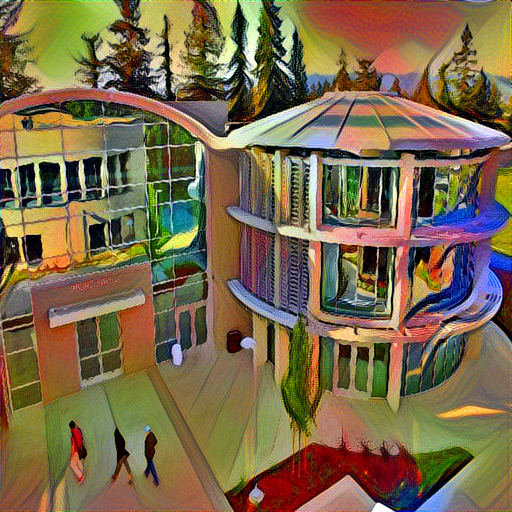

In [51]:
style_transferred_image

## Conclusion and further improvements

It's now your turn to play! Try changing the input images, their sizes, the weights of the different loss functions, the features used to construct them and enjoy different sorts of output. 

As beautiful as the output of this code can be, the process we use to generate it is quite slow. And no matter how much you speed this algorithm up (with GPUs and creative hacks), it is still going to be a relatively expensive problem to solve. This is because we're solving an entire optimisation problem each time we want to generate an image.


Next steps should implement a much faster version of this algorithm ([Johnson et al., 2016](https://arxiv.org/abs/1603.08155))